## Importing libraries and reading dataset

In [1]:
import cv2
import os
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

data_path = 'dataset/'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))  
print(label_dict)
print(categories)
print(labels)

{'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}
['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
[0, 1, 2, 3, 4]


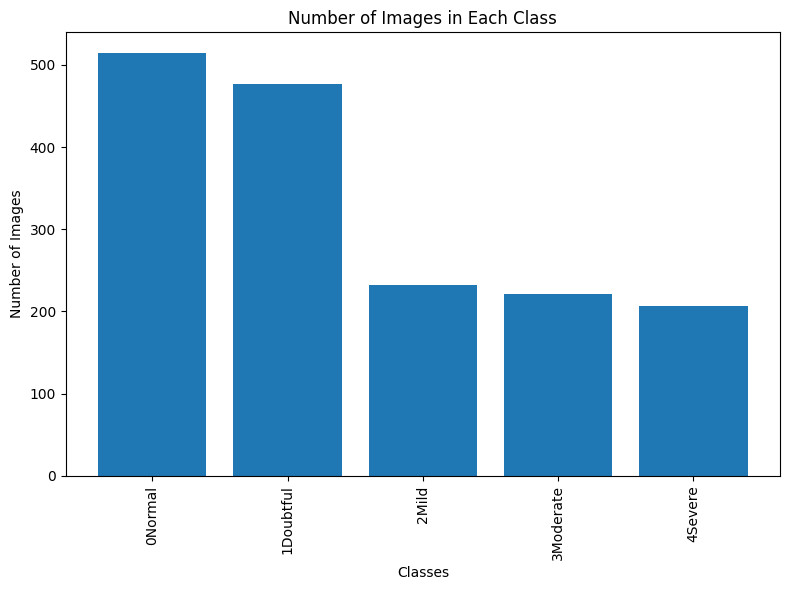

In [2]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for category in categories:
    class_path = os.path.join(data_path, category)
    num_images = len(os.listdir(class_path))
    class_counts[category] = num_images

plt.figure(figsize=(8, 6))  # Increase the figure width
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images in Each Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Increase rotation angle for better alignment
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Resizing and converting images into greyscale

In [3]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and placeholders
img_size = 224
data = []
label = []
original_images = []
clahe_images = []
hist_eq_images = []
gamma_images = []

# Updated categories and label mapping for Rheumatoid Arthritis detection
categories = ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
label_dict = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}

# # Data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.3,
#     height_shift_range=0.3,
#     shear_range=0.3,
#     zoom_range=0.3,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# Define data path (update path to your dataset)
data_path = "dataset/"

# CLAHE Parameters
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Function for gamma correction
def adjust_gamma(image, gamma=1.5):  # Adjust gamma value as needed
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Process the images: Original, CLAHE, Histogram Equalization, Gamma Correction, Bilateral Filtering, Laplacian Edge Detection
for category in tqdm(categories, desc="Processing categories"):
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            # Convert to grayscale and resize
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized_original = cv2.resize(gray, (img_size, img_size))

            # CLAHE enhancement
            clahe_img = clahe.apply(resized_original)

            # Histogram Equalization
            hist_eq_img = cv2.equalizeHist(clahe_img)

            # Gamma Correction
            gamma_img = adjust_gamma(hist_eq_img, gamma=1.5)

            # Append images for comparison
            original_images.append(resized_original)
            clahe_images.append(clahe_img)
            hist_eq_images.append(hist_eq_img)
            gamma_images.append(gamma_img)

            # Append to training data (you can choose which processed image to use)
            data.append(gamma_img)
            label.append(label_dict[category])  # Label remains the same

#             # Data augmentation
#             # Add a new axis for batch size, so shape becomes (1, 224, 224, 3)
#             augmented_images = datagen.flow(np.expand_dims(stacked_img, axis=0), batch_size=1)  # shape (1, 224, 224, 3)

#             # Generate only 1 augmented image
#             aug_img = next(augmented_images)[0].astype(np.uint8)  # Get the augmented image
#             data.append(aug_img)  # Add augmented image to data
#             label.append(label_dict[category])  # Add corresponding label
        except Exception as e:
            print('Exception:', e)  # Print exception and continue

Processing categories:   0%|          | 0/5 [00:00<?, ?it/s]

Processing categories: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


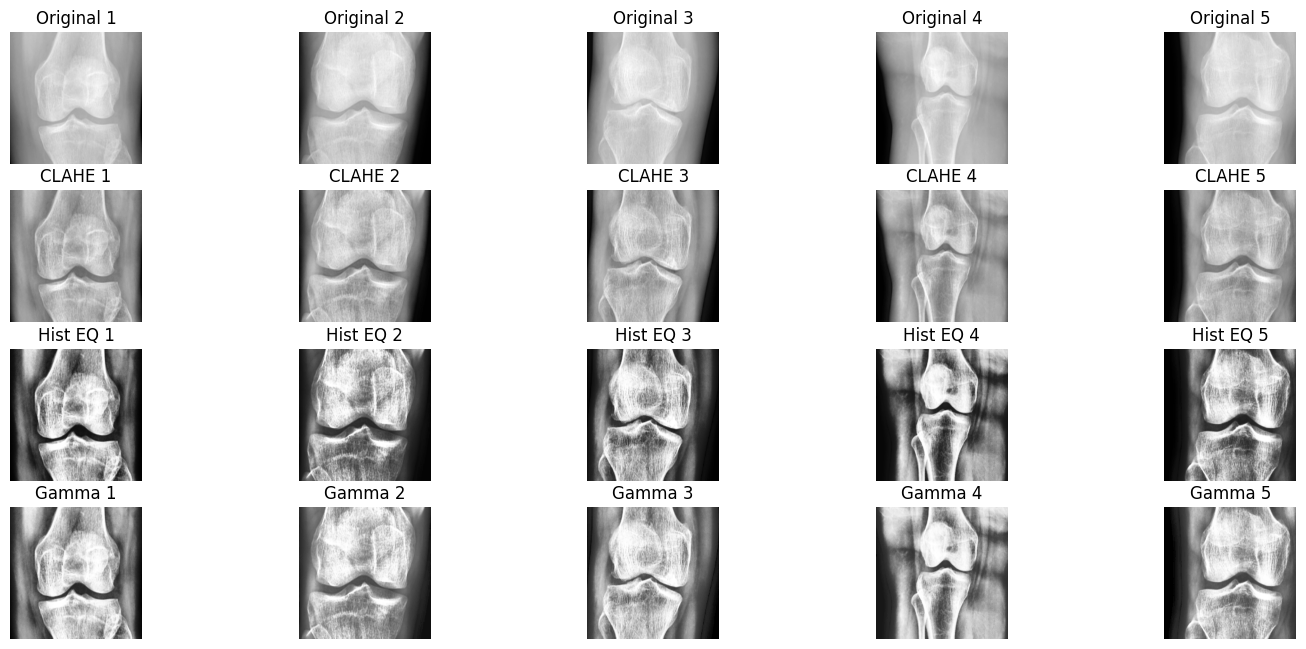

In [4]:
# Function to display the original and enhanced images
def display_all_algorithms(original, clahe, hist_eq, gamma, num_samples=5):
    plt.figure(figsize=(18, 12))

    for i in range(num_samples):
        # Display original image
        plt.subplot(6, num_samples, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Original {i+1}')

        # Display CLAHE image
        plt.subplot(6, num_samples, i + 1 + num_samples)
        plt.imshow(clahe[i], cmap='gray')
        plt.axis('off')
        plt.title(f'CLAHE {i+1}')

        # Display Histogram Equalization image
        plt.subplot(6, num_samples, i + 1 + 2*num_samples)
        plt.imshow(hist_eq[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Hist EQ {i+1}')

        # Display Gamma Corrected image
        plt.subplot(6, num_samples, i + 1 + 3*num_samples)
        plt.imshow(gamma[i], cmap='gray')
        plt.axis('off')
        plt.title(f'Gamma {i+1}')
    
    plt.show()

# Call the function to display 5 sample images processed by all algorithms
display_all_algorithms(original_images, clahe_images, hist_eq_images, gamma_images, num_samples=5)

In [5]:
data = np.array(data) / 255.0
data = np.stack((data,) * 3, axis=-1)  # stack grayscale images to create 3 channels
label = np.array(label)
new_label = to_categorical(label)

## Splitting dataset into testing and training

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.2, random_state=42)

## Resnet50

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import ResNet50V2

img_size = 224

# Load the pre-trained ResNet50V2 model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers in the base ResNet50V2 model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
x = base_model.output
x = Flatten()(x)

# Additional Dense and Dropout Layers
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

# Output Layer
predictions = Dense(len(categories), activation='softmax')(x)

# Define the input and output of the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of fac2f116257151a9d068a22e544a4917 so we will re-download the data.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 36,421,253 (138.94 MB)

 Trainable params: 12,856,069 (49.04 MB)

 Non-trainable params: 23,565,184 (89.89 MB)

In [8]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau

# lr_scheduler = LearningRateScheduler(lr_schedule)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    
# Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Define model checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint("models/model.keras", monitor='val_loss', save_best_only=True)

# Train the model with early stopping and model checkpoint callbacks
history_resnet = model.fit(x_train, y_train,
                        epochs=30, 
                        validation_data=(x_val, y_val),
                        callbacks=[lr_scheduler, checkpoint])

Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 912ms/step - accuracy: 0.1828 - loss: 2.2240 - val_accuracy: 0.3220 - val_loss: 1.6906 - learning_rate: 0.0010
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 27s 828ms/step - accuracy: 0.2926 - loss: 1.6538 - val_accuracy: 0.4621 - val_loss: 1.2971 - learning_rate: 0.0010
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 872ms/step - accuracy: 0.4205 - loss: 1.3917 - val_accuracy: 0.5379 - val_loss: 1.1339 - learning_rate: 0.0010
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 841ms/step - accuracy: 0.4799 - loss: 1.1996 - val_accuracy: 0.5492 - val_loss: 1.0643 - learning_rate: 0.0010
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 844ms/step - accuracy: 0.5003 - loss: 1.1983 - val_accuracy: 0.5795 - val_loss: 1.0304 - learning_rate: 0.0010
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 868ms/step - accuracy: 0.5542 - loss: 1.0669 - val_accuracy: 0.6326 - val_loss: 0.9345 - learning_rate: 0.0010
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 857ms/step - accuracy: 0.6332 - loss: 0.

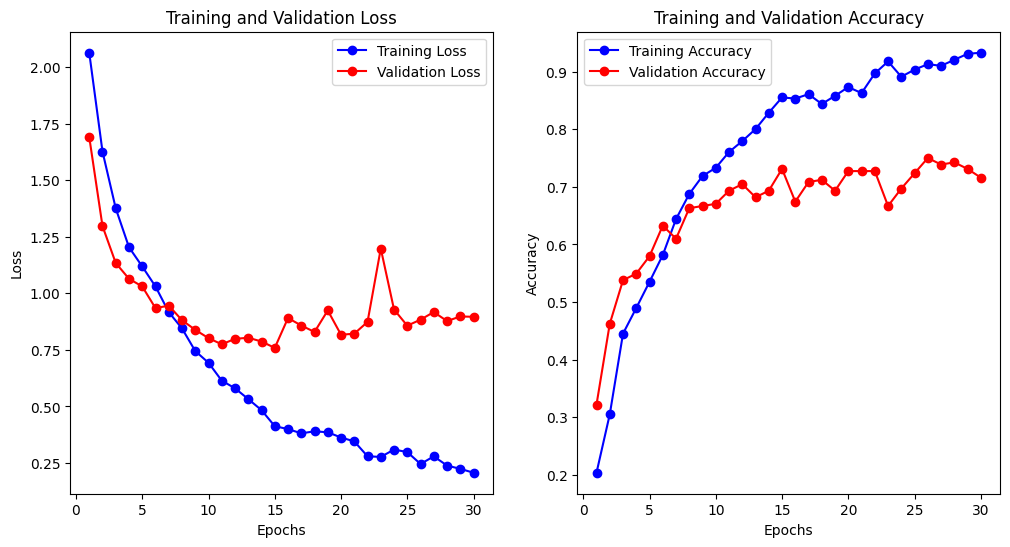

In [12]:
# Learning Curve
train_loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
train_accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy'] 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 1. Training and Validation Metrics
# Retrieve accuracy and loss for training and validation from history object
train_acc = history_resnet.history['accuracy'][-1]  # last epoch training accuracy
val_acc = history_resnet.history['val_accuracy'][-1]  # last epoch validation accuracy

# 2. Testing Metrics
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# Predict on the test set
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels
y_true = y_test.argmax(axis=1)  # If y_test is one-hot encoded, convert to class labels

# 3. Precision, Recall, F1 Score for Testing Set
precision = precision_score(y_true, y_pred_classes, average='weighted')  # 'weighted' for multi-class
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Print Results
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 774ms/step
Training Accuracy: 0.9328
Validation Accuracy: 0.7159
Test Accuracy: 0.7697
Precision: 0.7739
Recall: 0.7697
F1 Score: 0.7682


<!-- Normal - 64, 63, 69 (batch 32)
Clahe - 66, 65, 68 (batch 32)
Clahe + Hist - 69, 65, 70 (batch 32)
Clahe + Hist + Gamma - 71, 65, 71 (batch 32)
Clahe + Hist + Gamma - 80, 68, 72 (batch 16)
Clahe + Hist + Gamma + augmentation - 87, 57, 58 (batch 16) -->

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class Index: 4
Predicted Label: 4Severe
Prediction Probabilities: [[5.4656685e-04 9.8714128e-04 2.1653534e-03 2.5286777e-03 9.9377221e-01]]


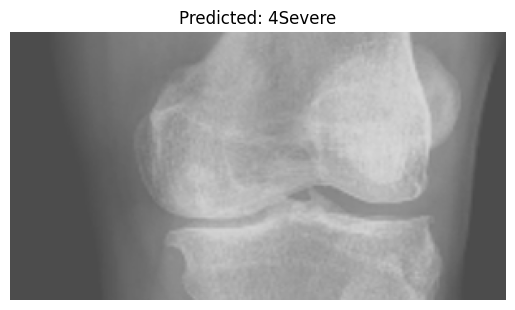

In [14]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model (make sure to update the path to your model)
model = load_model('models/model.keras')

# Define image size
img_size = 224

# Updated categories for Rheumatoid Arthritis detection
categories = ['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']

# Function for gamma correction
def adjust_gamma(image, gamma=1.5):  # Adjust gamma value as needed
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

# Function for preprocessing the image
def preprocess_image(img_path):
    # Read the image
    img = cv2.imread(img_path)
    # Convert to grayscale and resize
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (img_size, img_size))

    # CLAHE enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(resized)

    # Histogram Equalization
    hist_eq_img = cv2.equalizeHist(clahe_img)

    # Gamma Correction
    gamma_img = adjust_gamma(hist_eq_img, gamma=1.5)

    # Stack to create 3 channels
    stacked_img = np.concatenate([np.expand_dims(gamma_img, axis=-1)] * 3, axis=-1)  # Shape (224, 224, 3)
    
    # Normalize the image
    normalized_img = stacked_img / 255.0

    return np.expand_dims(normalized_img, axis=0)  # Shape (1, 224, 224, 3)

# Function to make predictions
def predict_image(img_path):
    preprocessed_img = preprocess_image(img_path)
    prediction = model.predict(preprocessed_img)
    predicted_class = np.argmax(prediction)  # Get the index of the highest probability
    return predicted_class, categories[predicted_class], prediction

# Example usage
img_path = 'img2.png'  # Update with your image path
predicted_class, predicted_label, prediction_probs = predict_image(img_path)

# Print the results
print(f'Predicted Class Index: {predicted_class}')
print(f'Predicted Label: {predicted_label}')
print(f'Prediction Probabilities: {prediction_probs}')

# Display the image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted: {predicted_label}')
plt.show()